In [1]:
!pip -q install torch-geometric -f https://data.pyg.org/whl/torch-1.11.0+cu113.html
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
import time
import h5py
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
import gc
from torch.optim import AdamW
import torch.optim as optim
import torchvision
from sklearn.feature_extraction.image import grid_to_graph
import pytorch_lightning as pl
import os

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
class CFG:
    train_batch_size=32
    val_batch_size=64
    k_neighbours=10
    n_epochs = 40
    train_size = 16000
    val_size = 2000
    test_size = 2000
    c_out = 2
    lr = 5e-4

In [5]:
%%time
f = h5py.File('/kaggle/input/quark-gluon-dataset/dataset.hdf5')
X = np.array(f['/X_jets'][:20000])
labels = np.array(f['/y'][:20000])
sz = len(X)

CPU times: user 8.67 s, sys: 4.93 s, total: 13.6 s
Wall time: 14.4 s


# Construction of graph

In [6]:
from sklearn.neighbors import kneighbors_graph
from sklearn.model_selection import train_test_split
from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader
from torch_geometric.nn import SAGEConv
from torch_geometric.nn import global_mean_pool

In [8]:
data = X.reshape((-1,X.shape[1]*X.shape[2],3))
non_zero_mask = np.any(data!=[0.0,0.0,0.0],axis=-1)
node_list = []
start_time = time.time()
for i,x in tqdm(enumerate(data)):
    node_list.append(x[non_zero_mask[i]])
print(time.time()-start_time)
start_time = time.time()
dataset = []
for i,nodes in tqdm(enumerate(node_list)):
    edges = kneighbors_graph(nodes,CFG.k_neighbours,mode='connectivity',include_self=True)
    c = edges.tocoo()
    edge_list = torch.from_numpy(np.vstack((c.row,c.col))).type(torch.long)
    edge_weight = torch.from_numpy(c.data.reshape(-1,1))
    y = torch.tensor([int(labels[i])],dtype=torch.long)
    data = Data(x=torch.from_numpy(nodes), edge_index=edge_list, edge_attr=edge_weight, y=y)
    dataset.append(data)
print(time.time()-start_time)
train_loader = DataLoader(dataset[:16000], batch_size=CFG.train_batch_size, shuffle=True,num_workers=2)
test_loader = DataLoader(dataset[16000:18000], batch_size=32, shuffle=False,num_workers=2)
val_loader = DataLoader(dataset[18000:], batch_size=CFG.val_batch_size, shuffle=False,num_workers=2)

20000it [00:01, 16615.42it/s]


1.2061340808868408


20000it [01:09, 286.29it/s]

69.91259169578552


In [9]:
data = dataset[0]
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Number of node features: {data.num_node_features}')
print(f'Number of edges features: {data.num_edge_features}')

print(dataset[0])

Number of nodes: 884
Number of edges: 8840
Number of node features: 3
Number of edges features: 1
Data(x=[884, 3], edge_index=[2, 8840], edge_attr=[8840, 1], y=[1])


In [10]:
del X
del labels
gc.collect()

1053

# Model

In [11]:
import torch.utils.data as data
class GraphSAGE(nn.Module):
    def __init__(self,c_in,c_hidden_conv,c_hidden_lin,c_out,dp_rate_linear=0.3):
        super(GraphSAGE,self).__init__()
        self.conv = nn.ModuleDict()
        self.len_conv = len(c_hidden_conv)+1
        self.len_lin = len(c_hidden_lin)
        self.conv[str(0)] = SAGEConv(c_in,c_hidden_conv[0])
        
        self.bn  =  nn.ModuleDict()
        self.bn[str(0)] = nn.BatchNorm1d(c_hidden_conv[0])
        for k in range(1,len(c_hidden_conv)):
            self.conv[str(k)] = SAGEConv(c_hidden_conv[k-1],c_hidden_conv[k])
            self.bn[str(k)] = nn.BatchNorm1d(c_hidden_conv[k])
        self.conv[str(len(c_hidden_conv))] = SAGEConv(c_hidden_conv[-1],c_hidden_lin[0])
        self.bn[str(len(c_hidden_conv))] = nn.BatchNorm1d(c_hidden_lin[0])
        self.lin = nn.ModuleDict()
        for k in range(1,len(c_hidden_lin)):
            self.lin[str(k)] = nn.Linear(c_hidden_lin[k-1],c_hidden_lin[k])
        self.out = nn.Linear(c_hidden_lin[-1],c_out)
        self.dp_rate_linear = dp_rate_linear
    def forward(self,x,edge_index,batch):
        for i in range(self.len_conv):
            x = self.conv[str(i)](x,edge_index)
            x =self.bn[str(i)](x)
            x = x.relu()
        x = global_mean_pool(x,batch)
        for i in range(1,self.len_lin):
            x = self.lin[str(i)](x)
            x = x.relu()
        x = self.out(x)
        return x

In [12]:
"""model = GraphSAGE(c_in=3, c_hidden_conv=[32,64,128],c_hidden_lin =[1024,512,256] ,c_out=2)
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0) # High lr because of small dataset and small model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loss_module = nn.BCEWithLogitsLoss() if CFG.c_out == 1 else nn.CrossEntropyLoss()
logs = {'training_loss':[],'training_accuracy':[],\
        'validation_loss':[],'validation_accuracy':[],\
        'batch_wise_trainloss':[],'batch_wise_val_loss':[]}
model.to(device)
for epoch in range(2):#range(CFG.n_epochs):
    #Training Loop
    ep_acc = 0
    for data in tqdm(iter(train_loader)):
        optimizer.zero_grad()
        data.to(device)
        x, edge_index, batch_idx = data.x, data.edge_index, data.batch
        ##Forward Pass
        x = model(x,edge_index,batch_idx)
        x = x.squeeze(dim=-1)
        
        if CFG.c_out == 1:
            preds = (x > 0).float()
            data.y = data.y.float()
        else:
            preds = x.argmax(dim=-1)
        loss = loss_module(x, data.y)
        ep_acc += (preds == data.y).sum().float().detach().cpu()# / preds.shape[0]
        
        ##Backprop
        loss.backward()
        optimizer.step()
        
        ###Logging
        logs['training_loss'].append(loss.detach().cpu().item())
        data=data.cpu()
        del data
        gc.collect()
    logs['training_accuracy'].append((ep_acc/CFG.train_size))
    ##Validation Loop
    ep_acc = 0
    model.eval()
    for data in tqdm(iter(val_loader)):
        optimizer.zero_grad()
        data.to(device)
        x, edge_index, batch_idx = data.x, data.edge_index, data.batch
        ##Forward Pass
        with torch.no_grad():
            x = model(x,edge_index,batch_idx)
            x = x.squeeze(dim=-1)

            if CFG.c_out == 1:
                preds = (x > 0).float()
                data.y = data.y.float()
            else:
                preds = x.argmax(dim=-1)
            loss = loss_module(x, data.y)
            ep_acc += (preds == data.y).sum().float().cpu()# / preds.shape[0]
        ###Logging
        logs['validation_loss'].append(loss.detach().cpu().item())
        data=data.cpu()
        del data
        gc.collect()
    logs['validation_accuracy'].append((ep_acc/CFG.val_size))
    print(f"Training Accuracy:{logs['training_accuracy'][-1]} Validation Accuracy:{logs['validation_accuracy'][-1]}")"""
"""Taking too much time, shifted to pytorch lightning"""

'Taking too much time, shifted to pytorch lightning'

In [13]:
#plt.plot(logs['training_loss'],color='r',label='Training loss')
#plt.show()

In [14]:
#plt.plot(logs['validation_loss'],color='g',label='Validation loss')

In [15]:
#plt.plot(logs['validation_accuracy'],c='g',label='Validation Accuracy')
#plt.plot(logs['training_accuracy'],c='r',label='Training Accuracy')
#plt.legend()
#plt.show()

In [16]:
class GraphLevelGNN(pl.LightningModule):
    def __init__(self, **model_kwargs):
        super(GraphLevelGNN,self).__init__()
        # Saving hyperparameters
        self.save_hyperparameters()
        self.model = GraphSAGE(**model_kwargs)
        self.loss_module = nn.BCEWithLogitsLoss() if self.hparams.c_out == 1 else nn.CrossEntropyLoss()

    def forward(self, data, mode="train"):
        x, edge_index, batch_idx = data.x, data.edge_index, data.batch
        # print(data.x.shape, data.edge_index.shape, data.batch.shape)
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        data.to(device=device)
        self.model.to(device=device)
        x = self.model(x, edge_index, batch_idx)
        x = x.squeeze(dim=-1)
        
        if self.hparams.c_out == 1:
            preds = (x > 0).float()
            data.y = data.y.float()
        else:
            preds = x.argmax(dim=-1)

        loss = self.loss_module(x, data.y)
        acc = (preds == data.y).sum().float() / preds.shape[0]
        
        return loss, acc

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=CFG.lr, weight_decay=0) # High lr because of small dataset and small model
        return optimizer

    def training_step(self, batch, batch_idx):
        loss, acc = self.forward(batch, mode="train")
        self.log('train_loss', loss, prog_bar=True,logger=True)
        self.log('train_acc', acc, prog_bar=True,logger=True)
        
        return loss

    def validation_step(self, batch, batch_idx):
        loss, acc = self.forward(batch, mode="val")
        self.log('val_loss', loss, on_epoch=True, prog_bar=False,logger=True)
        self.log('val_acc', acc, on_epoch=True, prog_bar=False,logger=True)

    def test_step(self, batch, batch_idx):
        loss, acc = self.forward(batch, mode="test")
        self.log('test_loss', loss, on_epoch=True, prog_bar=False)
        self.log('test_acc', acc, on_epoch=True, prog_bar=False)

def train_graph_classifier(model_name,logger, **model_kwargs):
    pl.seed_everything(17)
    
    trainer = pl.Trainer(accelerator='auto',
                         max_epochs=CFG.n_epochs,logger=logger)

    # Check whether pretrained model exists. If yes, load it and skip training
    model = GraphLevelGNN(**model_kwargs)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    trainer.fit(model, train_loader, val_loader)
    model = GraphLevelGNN.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)
    model.to(device)
    # Test best model on validation and test set
    # train_result = trainer.test(model, dataloaders=train_loader, verbose=False)
    val_result = trainer.test(model, dataloaders=val_loader, verbose=False)
    test_result = trainer.test(model, dataloaders=test_loader, verbose=False)
    result = {"test": test_result[0]['test_acc'], "valid": val_result[0]['test_acc']} 
    return trainer, model, result


In [17]:
import os
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logger = pl.loggers.CSVLogger(save_dir='logs/', name='GraphSAGE')
trainer, model, result = train_graph_classifier(model_name="GraphSAGE",logger=logger,c_in=3, c_hidden_conv=[32,64,128],c_hidden_lin =[1024,512,256] ,c_out=2)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

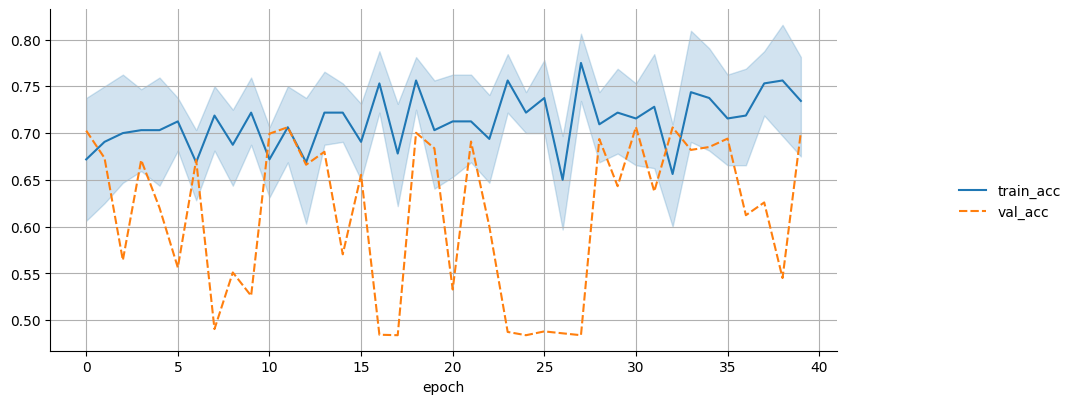

In [18]:
import seaborn as sn

metrics = pd.read_csv(f'{trainer.logger.log_dir}/metrics.csv')
del metrics["step"]
del metrics['test_loss']
del metrics['test_acc']
del metrics['train_loss']
del metrics['val_loss']
metrics.set_index("epoch", inplace=True)
# display(metrics.dropna(axis=1, how="all").head())
g = sn.relplot(data=metrics, kind="line")
plt.gcf().set_size_inches(12, 4)
# plt.gca().set_yscale('log')
plt.grid()

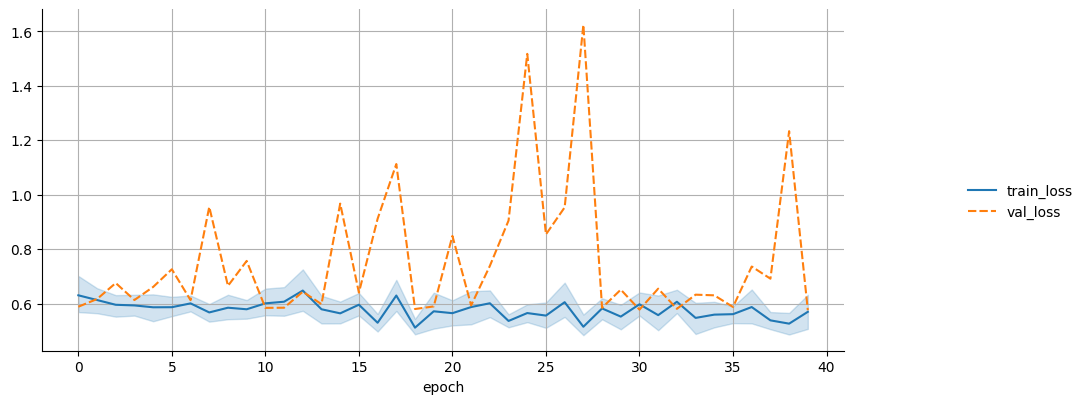

In [19]:
metrics = pd.read_csv(f'{trainer.logger.log_dir}/metrics.csv')
del metrics["step"]
del metrics['test_loss']
del metrics['test_acc']
del metrics['train_acc']
del metrics['val_acc']
metrics.set_index("epoch", inplace=True)
# display(metrics.dropna(axis=1, how="all").head())
g = sn.relplot(data=metrics, kind="line")
plt.gcf().set_size_inches(12, 4)
# plt.gca().set_yscale('log')
plt.grid()

# Discussion
I have used K-nearest neighbours to construct the graph from the point cloud \
I have used stack of GraphSAGEconv layers and the graphs above show the result \
Learning rate, preprocessing can be explored more to improve the training \
Different architectures like GAT can be explored and ablation studies can further help determine the depth and other choices of the architecture